In [1]:
import pandas as pd
from utils import *
from sklearn.ensemble import RandomForestClassifier
from tqdm.notebook import trange, tqdm
from time import sleep
from component_store import GeneticAlgorithmComponent
import numpy as np
from evaluation import *
import matplotlib.pyplot as plt

# Internals

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

def get_team_names(year):
    df = pd.read_csv(f"{DATA_DIR}/cleaned_bracket_data.csv", index_col=0)
    df = df[(df["year"] == year) & (df["round"] == 1)]
    start_team_names = df[["team1", "team2"]].reset_index().melt(id_vars=['index'], value_vars=['team1', 'team2']).sort_values(["index", "variable"]).reset_index(drop=True)["value"]
    start_team_names = pd.merge(start_team_names, df[["team1", "team1seed"]], how="left", left_on="value", right_on="team1").rename({"team1seed":"SEED"}, axis=1).drop("team1", axis=1)
    start_team_names = pd.merge(start_team_names, df[["team2", "team2seed"]], how="left", left_on="value", right_on="team2").drop("team2", axis=1)
    start_team_names.loc[start_team_names["SEED"].isna(), "SEED"] = start_team_names["team2seed"]
    start_team_names = start_team_names.drop("team2seed", axis=1)
    return start_team_names

def data_setup(train_start, train_end, test_year, team_names, population_size, features, model=RandomForestClassifier, params=None, brackets_per_individual=5, test_brackets=100):
    train_acc, test_acc, clf = run_pipe(train_start, train_end, train_start-1, features, model=model, params=params)
    print(train_acc, test_acc)
    raw_brackets = generate_brackets_np(clf, features, team_names, test_year, (population_size * brackets_per_individual)+test_brackets)
    print(raw_brackets.shape)
    brackets, test_set = raw_brackets[:-test_brackets], raw_brackets[-test_brackets:]
    brackets = brackets.reshape((population_size, brackets_per_individual, 63))
    return brackets, test_set

In [3]:
def eval_on_bracket(ind_true_bracket, init_pop):
    ind_true_bracket = np.tile(ind_true_bracket, [init_pop.shape[0], init_pop.shape[1], 1])
    results = init_pop == ind_true_bracket
    population_size, brackets_per_individual, _ = init_pop.shape
    preds = init_pop.copy()

    rounds =  [i + 2 for i in range(5)]
    round_lens = [16 // 2 ** (round - 2) for round in rounds]
    start_inds = [32, 32+16, 32+16+8, 32+16+8+4, 32+16+8+4+2]

    arr = []
    for i in range(6):
        arr = arr + [(2**i)]*(32//(2**i))
    point_values = np.tile(np.array(arr), (population_size, brackets_per_individual, 1))


    for round, round_len, start_ind in zip(rounds, round_lens, start_inds):
        for game in [start_ind + i for i in range(round_len)]:
            prereq_game_ind = (game-(2*round_len) + (game - start_ind) + (preds[:, :, game]).astype(int))#.reshape(2, 1, 1)
            prereq_results = results[:, :, prereq_game_ind][np.arange(population_size), :, np.arange(population_size), :][:, np.arange(brackets_per_individual), np.arange(brackets_per_individual)].reshape(results[:, :, game].shape)
            updated_results = np.logical_and(prereq_results, results[:, :, game])
            results[:, :, game] = updated_results

    fitness_per_individual = (point_values * results).sum(axis=2).max(axis=1)
    return fitness_per_individual

def fitness(init_pop, test_set):
    # TODO: vectorize this to improve efficiency for larger test sets
    return np.apply_along_axis(eval_on_bracket, 1, test_set, init_pop).mean(axis=0)

def softmax(x, em=1):
    em_x = x**em
    e_x = np.exp(em_x - em_x.max())
    return e_x / e_x.sum()

def selection(population, fitnesses, num_elites=0, emphasis=1):
    # print(softmax(fitnesses, emphasis))
    pop_size = population.shape[0]
    num_children_needed = population.shape[0] - num_elites
    # print(pop_size, num_children_needed)
    left_inds = np.random.choice(pop_size, num_children_needed, True, softmax(fitnesses, emphasis))
    right_inds = np.random.choice(pop_size, num_children_needed, True, softmax(fitnesses, emphasis))
    # print(left_inds)
    return population[left_inds], population[right_inds]

def combine(left_parents, right_parents):
    mask = np.random.binomial(1, 0.5, left_parents.shape)
    children = left_parents.copy()
    children[mask == 1] = right_parents[mask == 1]
    return children

def mutate(init_pop, mutation_rate):
    noise = np.random.binomial(1, mutation_rate, init_pop.shape)
    new_pop = np.logical_xor(init_pop, noise).astype(int)
    return new_pop

def generation(population, test_set, num_elites=3, emph=0.75, mr=1/1000):
    fitnesses = fitness(population, test_set)

    left_parents, right_parents = selection(population, fitnesses, num_elites=num_elites, emphasis=emph)
    children = mutate(combine(left_parents, right_parents), mutation_rate=mr)
    # print(children.shape)
    if num_elites > 0:
        elite_inds = np.argsort(fitnesses)[-num_elites:]
        elites = population[elite_inds]

        new_population = np.concatenate((children, elites), axis=0)
    else:
        new_population = children
    return new_population

def print_individual(individual, start_team_names):
    for bracket_ind in range(individual.shape[0]):
        round_1 = start_team_names.iloc[((np.arange(32) * 2) + individual[bracket_ind][:32])].reset_index(drop=True)
        round_2 = round_1.iloc[((np.arange(16) * 2) + individual[bracket_ind][32:32+16])].reset_index(drop=True)
        round_3 = round_2.iloc[((np.arange(8) * 2) + individual[bracket_ind][32+16:32+16+8])].reset_index(drop=True)
        round_4 = round_3.iloc[((np.arange(4) * 2) + individual[bracket_ind][32+16+8:32+16+8+4])].reset_index(drop=True)
        round_5 = round_4.iloc[((np.arange(2) * 2) + individual[bracket_ind][32+16+8+4:32+16+8+4+2])].reset_index(drop=True)
        round_6 = round_5.iloc[((np.arange(1) * 2) + individual[bracket_ind][32+16+8+4+2:32+16+8+4+2+1])].reset_index(drop=True)
        print(pd.concat([round_1, round_2, round_3, round_4, round_5, round_6], axis=1).fillna(""))

def run_gym(
        pop,
        test_set,
        num_elites = 1, 
        emph = 0.75, 
        mr=1/1000, 
        test_subset_size = 40, 
        num_gens = 10000, 
        log_fitness=True, 
        log_freq=1000, 
        change_hps=True,
        early_stop=True
):  
    last_fitness = 0.0
    best_fits = np.zeros((1))
    mean_fits = np.zeros((1))
    for i in trange(num_gens):
        if change_hps:
            test_subset_size = min(min(test_set.shape[0], 100), int(1/50 * i + 10))
            mr = 1/(i+100)
        test_subset = test_set[np.random.choice(np.arange(test_set.shape[0]), min(test_subset_size, test_set.shape[0]), False)]
        pop = generation(pop, test_subset, num_elites=num_elites, emph=emph, mr=mr)
        # print(fits[-1])
        if log_fitness and (i % log_freq == 0):
            fits = fitness(pop, test_set)
            best_fits = np.concatenate((best_fits, [fits.max()]))
            mean_fits = np.concatenate((mean_fits, [fits.mean()]))
            if early_stop and (fits.max() < last_fitness*1.001):
                return pop, best_fits, mean_fits
    
    return pop, best_fits, mean_fits

In [4]:
target_year = 2023
features = best_features

rand_forest_best = {
    "max_depth": 10,
    "min_samples_split": 4,
    "min_samples_leaf": 2,
}
lookback = 10
train_end = target_year - 1
train_start = train_end - lookback

In [5]:

train_acc, test_acc, clf = run_pipe(2002, 2022, 2023, best_features, model=RandomForestClassifier, params=rand_forest_best)
print(train_acc, test_acc)

0.955064737242955 0.7089552238805971


In [6]:
team_names = pd.DataFrame(
    [
        ["Connecticut", 1],
        ["Stetson", 16],
        ["Florida Atlantic", 8],
        ["Northwestern", 9],
        ["San Diego St.", 5],
        ["UAB", 12],
        ["Auburn", 4],
        ["Yale", 13],
        ["BYU", 6],
        ["Duquesne", 11],
        ["Illinois", 3],
        ["Morehead St.", 14],
        ["Washington St.", 7],
        ["Drake", 10],
        ["Iowa St.", 2],
        ["South Dakota St.", 15],
        
        ["North Carolina", 1],
        ["Howard", 16],#play-in
        ["Mississippi St.", 8],
        ["Michigan St.", 9],
        ["Saint Mary's", 5],
        ["Grand Canyon", 12],
        ["Alabama", 4],
        ["College of Charleston", 13],
        ["Clemson", 6],
        ["New Mexico", 11],
        ["Baylor", 3],
        ["Colgate", 14],
        ["Dayton", 7],
        ["Nevada", 10],
        ["Arizona", 2],
        ["Long Beach St.", 15],

        ["Houston", 1],
        ["Longwood", 16],
        ["Nebraska", 8],
        ["Texas A&M", 9],
        ["Wisconsin", 5],
        ["James Madison", 12],
        ["Duke", 4],
        ["Vermont", 13],
        ["Texas Tech", 6],
        ["N.C. State", 11],
        ["Kentucky", 3],
        ["Oakland", 14],
        ["Florida", 7],
        ["Colorado", 10],#play-in
        ["Marquette", 2],
        ["Western Kentucky", 15],
        
        ["Purdue", 1],
        ["Montana", 16],#play-in
        ["Utah St.", 8],
        ["TCU", 9],
        ["Gonzaga", 5],
        ["McNeese St.", 12],
        ["Kansas", 4],
        ["Samford", 13],
        ["South Carolina", 6],
        ["Oregon", 11],
        ["Creighton", 3],
        ["Akron", 14],
        ["Texas", 7],
        ["Colorado St.", 10],#play-in
        ["Tennessee", 2],
        ["Saint Peter's", 15],
    ], 
    columns=["value", "SEED"]
)
team_names["SEED"] = team_names["SEED"].astype(float)

# Code

In [20]:
population_size = 20
brackets_per_individual = 100
num_test_brackets = 10000

num_elites = 5
emph = 1.0
mr=1/1000
test_subset_size = 2000
num_gens = 6000

In [16]:
brackets, test_set = data_setup(2003, 2023, target_year, team_names, population_size, features, model=RandomForestClassifier, params=rand_forest_best, brackets_per_individual=brackets_per_individual, test_brackets=num_test_brackets)
# brackets, test_set

0.9449088145896657 0.765625


100%|██████████| 12000/12000 [43:04<00:00,  4.64it/s]

(12000, 63)


In [17]:
brackets.shape

(20, 100, 63)

In [21]:
pop, best_fits, mean_fits = run_gym(
    # np.random.binomial(1, 0.5, (population_size, brackets_per_individual, 63)),
    # pop,
    brackets,
    test_set,
    num_elites = num_elites, 
    emph = emph, 
    mr=mr, 
    test_subset_size = test_subset_size, 
    num_gens = num_gens, 
    log_fitness=True, 
    log_freq=2000, 
    change_hps=True,
    early_stop=True
)


 55%|█████▍    | 3290/6000 [5:00:14<4:07:18,  5.48s/it]   


KeyboardInterrupt: 

In [ ]:
pop, best_fits, mean_fits = run_gym(
    # np.random.binomial(1, 0.5, (population_size, brackets_per_individual, 63)),
    pop,
    # brackets,
    test_set,
    num_elites = num_elites, 
    emph = emph, 
    mr=mr, 
    test_subset_size = 4*population_size, 
    num_gens = num_gens, 
    log_fitness=False, 
    log_freq=1000, 
    change_hps=True,
    early_stop=True
)

In [ ]:
expected_fitness_rand = np.round(fitness(np.random.binomial(1, 0.5, (100, brackets_per_individual, 63)), test_set).mean(), 2)
expected_fitness_model = np.round(fitness(brackets, test_set).mean(), 2)

Expected Best Bracket Scores for 100 Brackets:
50/50 chance:		91.57
Trained model alone:	133.4
Genetic Algorithm:	124.36


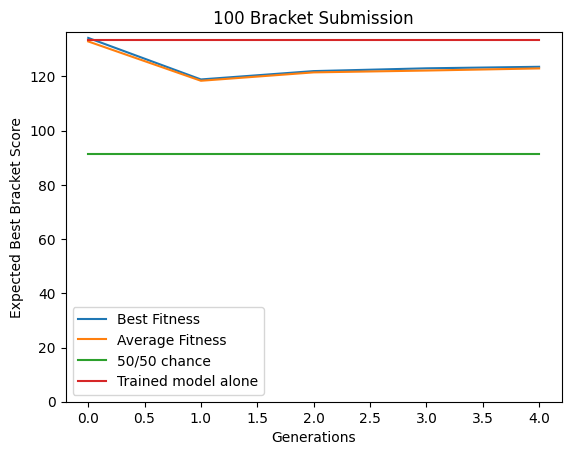

In [ ]:

expected_fitness_ga = np.round(fitness(pop, test_set).mean(), 2)
print(f"Expected Best Bracket Scores for {brackets_per_individual} Brackets:\n50/50 chance:\t\t{expected_fitness_rand}\nTrained model alone:\t{expected_fitness_model}\nGenetic Algorithm:\t{expected_fitness_ga}")

# plt.plot(np.arange(len(best_fits) - 1), _best_fits[1:], label="a. Best Fitness")
# plt.plot(np.arange(len(best_fits) - 1), _mean_fits[1:], label="a. Average Fitness")
plt.plot(np.arange(len(best_fits) - 1), best_fits[1:], label="Best Fitness")
plt.plot(np.arange(len(best_fits) - 1), mean_fits[1:], label="Average Fitness")
plt.plot(np.arange(len(best_fits) - 1), np.ones(len(best_fits) - 1) * expected_fitness_rand, label="50/50 chance")
plt.plot(np.arange(len(best_fits) - 1), np.ones(len(best_fits) - 1) * expected_fitness_model, label="Trained model alone")
plt.xlabel("Generations")
plt.ylabel("Expected Best Bracket Score")
plt.ylim(0)
plt.title(f"{brackets_per_individual} Bracket Submission")
plt.legend()
plt.show()

In [108]:
best_ind = pop[fitness(pop, test_set).argmax()].astype('int32') 

print_individual(best_ind, team_names)
# best_ind.shape

               value  SEED          value SEED        value SEED        value SEED    value SEED    value SEED
0        Connecticut   1.0    Connecticut  1.0  Connecticut  1.0  Connecticut  1.0  Alabama  4.0  Alabama  4.0
1   Florida Atlantic   8.0  San Diego St.  5.0     Iowa St.  2.0      Alabama  4.0   Purdue  1.0              
2      San Diego St.   5.0       Illinois  3.0      Alabama  4.0      Houston  1.0                            
3             Auburn   4.0       Iowa St.  2.0       Baylor  3.0       Purdue  1.0                            
4                BYU   6.0   Michigan St.  9.0      Houston  1.0                                              
5           Illinois   3.0        Alabama  4.0    Marquette  2.0                                              
6              Drake  10.0         Baylor  3.0       Purdue  1.0                                              
7           Iowa St.   2.0        Arizona  2.0        Texas  7.0                                              
8

In [106]:

print_individual(best_ind, team_names)

               value  SEED          value SEED        value SEED        value SEED      value SEED    value SEED
0        Connecticut   1.0    Connecticut  1.0  Connecticut  1.0  Connecticut  1.0    Alabama  4.0  Alabama  4.0
1   Florida Atlantic   8.0  San Diego St.  5.0     Iowa St.  2.0      Alabama  4.0  Tennessee  2.0              
2      San Diego St.   5.0       Illinois  3.0      Alabama  4.0      Houston  1.0                              
3             Auburn   4.0       Iowa St.  2.0       Baylor  3.0    Tennessee  2.0                              
4                BYU   6.0   Michigan St.  9.0      Houston  1.0                                                
5           Illinois   3.0        Alabama  4.0    Marquette  2.0                                                
6     Washington St.   7.0         Baylor  3.0       Kansas  4.0                                                
7           Iowa St.   2.0        Arizona  2.0    Tennessee  2.0                                

In [105]:
best_ind[0][31+16] = 1

In [107]:
fitness(best_ind.reshape((1, -1, 63)), test_set)

array([114.4758])

In [95]:
fitness(best_ind.reshape((1, -1, 63)), test_set)

array([115.1086])

In [89]:
fitness(pop, test_set).argmax()

9

In [90]:
fitness(pop, test_set)

array([114.9216, 111.8712, 115.0917, 115.1052, 115.0584, 115.0257,
       115.0242, 115.0498, 115.0584, 115.1086, 115.0917, 114.9252,
       115.0606, 115.0257, 115.1052, 115.0614, 115.1068, 115.0924,
       114.9831, 115.0374, 114.9105, 115.003 , 115.0924, 115.0584,
       115.1068, 115.0368, 115.0917, 115.0257, 115.0128, 115.0924,
       115.0742, 115.1086, 115.068 , 115.0924, 115.0584, 115.0584,
       113.6485, 115.0257, 114.975 , 115.0917, 115.1068, 115.0856,
       115.1068, 115.1068, 115.0924, 114.9936, 115.1052, 115.0584,
       115.0917, 115.0614, 115.0924, 115.0561, 115.0291, 114.9573,
       115.0924, 115.0496, 115.0257, 115.0257, 114.975 , 115.1068,
       115.0917, 114.9048, 115.0924, 114.9831, 115.1068, 115.1068,
       115.1052, 115.0584, 115.0924, 115.008 , 115.0257, 115.1068,
       114.9259, 115.0924, 115.0701, 114.7611, 115.1052, 115.0473,
       115.1052, 115.1068, 115.0924, 115.1068, 115.0291, 115.1068,
       115.0453, 115.0453, 115.0453, 115.0924, 115.0924, 115.0

In [43]:
# rand_forest_best = {
#     "max_depth": 10,
#     "min_samples_split": 4,
#     "min_samples_leaf": 2,
# }
# lookback = 10
# train_end = target_year - 1
# train_start = train_end - lookback
# train_score, test_score, clf = run_pipe(train_start, train_end, min(2023,target_year), features, model=RandomForestClassifier, params=rand_forest_best)


In [71]:
df = pd.read_csv(f"{DATA_DIR}/kenpom.csv", index_col=0)
df = df[df["YEAR"] == 2024]

In [80]:
shift_teams = {
    "value": [
        "Illinois",
        "Iowa St.",
        "North Carolina",
        "Kentucky",
    ],
    "SEED": [3.0, 2.0, 1.0, 16.0]
}
# shift_df = df[df["TEAM"].isin(shift_teams)].set_index("TEAM").T[shift_teams].T.reset_index()
# shift_df
# pd.DataFrame(shift_teams)
clf.predict_proba(make_X_from_teams(pd.DataFrame(shift_teams), 2024, best_features))

array([[0.40457461, 0.59542539],
       [0.63474876, 0.36525124]])

In [ ]:
team_name_df = pd.DataFrame(
    shift_teams, columns=["TEAM"]
)
team_name_df = team_name_df.merge(team_names, left_on="TEAM", right_on="value", how="left")
team_name_df["SEED"] = pd.Series([16, 16, 10, 10, 16, 16, 10, 10]).astype(float)
# team_name_df = team_name_df.merge(team_names, left_on="TEAM", right_on="value", how="left")
team_name_df["value"] = team_name_df["TEAM"]
team_name_df = team_name_df[["value", "SEED"]]
team_name_df

In [ ]:
clf.predict_proba(make_X_from_teams(team_name_df, 2024, best_features))

In [27]:

play_ins = [
    "Howard",
    "Wagner",
    "Colorado St.",
    "Virginia",
    "Grambling St.",
    "Montana St.",
    "Colorado",
    "Boise St.",
]
play_in_df = df[df["TEAM"].isin(play_ins)].set_index("TEAM").T[play_ins].T.reset_index()

In [28]:
team_names

,value,SEED
0,Connecticut,1.0
1,Stetson,16.0
2,Florida Atlantic,8.0
3,Northwestern,9.0
4,San Diego St.,5.0
5,UAB,12.0
6,Auburn,4.0
7,Yale,13.0
8,BYU,6.0
9,Duquesne,11.0


In [29]:
team_name_df = pd.DataFrame(
    play_ins, columns=["TEAM"]
)
team_name_df = team_name_df.merge(team_names, left_on="TEAM", right_on="value", how="left")
team_name_df["SEED"] = pd.Series([16, 16, 10, 10, 16, 16, 10, 10]).astype(float)
# team_name_df = team_name_df.merge(team_names, left_on="TEAM", right_on="value", how="left")
team_name_df["value"] = team_name_df["TEAM"]
team_name_df = team_name_df[["value", "SEED"]]
team_name_df

,value,SEED
0,Howard,16.0
1,Wagner,16.0
2,Colorado St.,10.0
3,Virginia,10.0
4,Grambling St.,16.0
5,Montana St.,16.0
6,Colorado,10.0
7,Boise St.,10.0


In [30]:
clf.predict_proba(make_X_from_teams(team_name_df, 2024, best_features))

array([[0.5617658 , 0.4382342 ],
       [0.49093923, 0.50906077],
       [0.60081076, 0.39918924],
       [0.38914343, 0.61085657]])

In [31]:

team_names[team_names["value"].isin(["Texas", "Tennessee"])]

,value,SEED
60,Texas,7.0
62,Tennessee,2.0


In [32]:
clf.predict_proba(make_X_from_teams(team_names[team_names["value"].isin(["Texas", "Purdue"])], 2024, best_features))

array([[0.85592354, 0.14407646]])

In [114]:
r2 = team_names.iloc[clf.predict(make_X_from_teams(team_names, 2024, best_features)) + (np.arange(32) * 2)]
r2

,value,SEED
0,Connecticut,1.0
2,Florida Atlantic,8.0
4,San Diego St.,5.0
6,Auburn,4.0
8,BYU,6.0
11,Morehead St.,14.0
13,Drake,10.0
14,Iowa St.,2.0
16,North Carolina,1.0
19,Michigan St.,9.0


In [116]:
r3 = r2.iloc[clf.predict(make_X_from_teams(r2, 2024, best_features)) + (np.arange(16) * 2)]
r3

,value,SEED
0,Connecticut,1.0
4,San Diego St.,5.0
8,BYU,6.0
14,Iowa St.,2.0
19,Michigan St.,9.0
22,Alabama,4.0
26,Baylor,3.0
30,Arizona,2.0
35,Texas A&M,9.0
38,Duke,4.0


In [117]:
r4 = r3.iloc[clf.predict(make_X_from_teams(r3, 2024, best_features)) + (np.arange(8) * 2)]
r4

,value,SEED
0,Connecticut,1.0
8,BYU,6.0
22,Alabama,4.0
26,Baylor,3.0
35,Texas A&M,9.0
46,Marquette,2.0
48,Purdue,1.0
62,Tennessee,2.0


In [118]:
r5 = r4.iloc[clf.predict(make_X_from_teams(r4, 2024, best_features)) + (np.arange(4) * 2)]
r5

,value,SEED
0,Connecticut,1.0
26,Baylor,3.0
46,Marquette,2.0
48,Purdue,1.0


In [119]:
r6 = r5.iloc[clf.predict(make_X_from_teams(r5, 2024, best_features)) + (np.arange(2) * 2)]
r6

,value,SEED
26,Baylor,3.0
48,Purdue,1.0


In [121]:
r7 = r6.iloc[clf.predict(make_X_from_teams(r6, 2024, best_features)) + (np.arange(1) * 2)]
r7

,value,SEED
48,Purdue,1.0


In [186]:
np.random.random()*2

1.4226083213484064